In [1]:
import os
import cv2
import glob
from glob import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from IPython.display import display

In [2]:
def im_multi(path):
    try:
        #print(path)
        im_stats_im_ = cv2.imread(path)
        #print(im_stats_im_.size)
        return [path, {'size': im_stats_im_.size}]
    except:
        print("Error path:%s"%(path))
        return [path, {'size': [0,0]}]
    
def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        #print(ret[i][0])
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join([str(s) for s in str(im_stats_d[x]['size'])]))
    return im_stats_df

def get_im_cv2(args):
    img = cv2.imread(args[0])
    resized = cv2.resize(img, (args[1], args[1]), cv2.INTER_LINEAR)
    return [args[0], resized]

def image_features(paths, dim):
    imf_d = {}
    p = Pool(cpu_count())
    dims = [dim for i in range(len(paths.tolist()))]
    params = list(zip(paths.tolist(), dims))
    ret = p.map(get_im_cv2, params)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype = np.uint8)
    #fdata = fdata.transpose((0, 3, 1, 2)) # channels 放到前面
    #fdata = fdata.astype('float32') 
    #fdata = fdata / 255
    return fdata

In [3]:
basepath = '/home/dataset/train/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1]
    #print(cervix_type)
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,/home/dataset/train/Type_1/0.jpg,jpg,Type_1
1,/home/dataset/train/Type_1/10.jpg,jpg,Type_1
2,/home/dataset/train/Type_1/1013.jpg,jpg,Type_1
3,/home/dataset/train/Type_1/1014.jpg,jpg,Type_1
4,/home/dataset/train/Type_1/1019.jpg,jpg,Type_1


In [5]:
import glob
train = glob.glob('/home/dataset/train/**/*.jpg')# + glob.glob('/data/kaggle/additional/**/*.jpg')
train =\
pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train], columns = ['type','image','path'])#[:40]

In [28]:
#test_img = cv2.imread(test_img_path)

In [35]:
#cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY).shape

In [13]:
dim = 256
def showX(X, dim):
    int_X = X
    if X.shape == 3:
        int_X_reshape = int_X.reshape(-1,dim,dim,3).swapaxes(0,1).reshape(dim,-1,3)
    else:
        int_X_reshape = int_X
    display(Image.fromarray(int_X_reshape))

In [34]:
train_ = im_stats(train)
train_1 = train_[train_['size'] != '0 0'].reset_index(drop=True) #remove bad images
train_data = image_features(train_1['path'], dim)

In [36]:
train_data[0].shape

(256, 256, 3)

In [180]:
image = train_data[:,:,:,::-1][0]

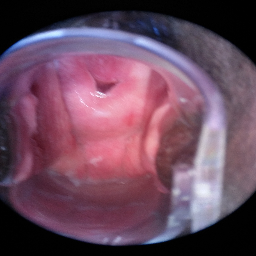

In [181]:
showX(image, dim)

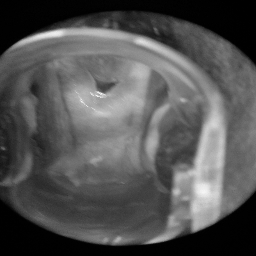

In [90]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
showX(image_gray,dim)

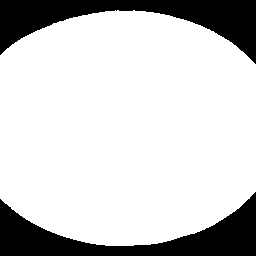

In [93]:
ret, threshold = cv2.threshold(image_gray, 12, 255, cv2.THRESH_BINARY)
showX(threshold,dim)

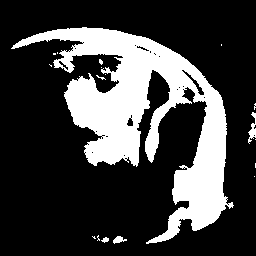

In [117]:
ret, threshold = cv2.threshold(image_gray, 120, 255, cv2.THRESH_BINARY)
showX(threshold, dim)

In [118]:
#Find all the contours in thresh. In your case the 3 and the additional strike
im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [129]:
im2.shape, hierarchy.shape

((256, 256), (1, 50, 4))

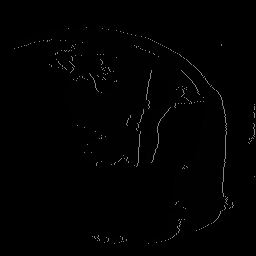

In [119]:
showX(im2,dim)

In [135]:
# Let (x,y) be the top-left coordinate of the rectangle and (w,h) be its width and height.
# x,y,w,h = cv2.boundingRect(cnt)
rects = [cv2.boundingRect(cnt) for cnt in contours]

In [139]:
top_x = min([x for (x, y, w, h) in rects])
top_y = min([y for (x, y, w, h) in rects])
bottom_x = max([x+w for (x, y, w, h) in rects])
bottom_y = max([y+h for (x, y, w, h) in rects])

In [190]:
out = cv2.rectangle(image_gray, (top_x, top_y), (bottom_x, bottom_y), (255, 0, 0), 2)
crop = image[top_y:bottom_y,top_x:bottom_x]

In [186]:
top_x, top_y, bottom_x, bottom_y

(11, 27, 255, 244)

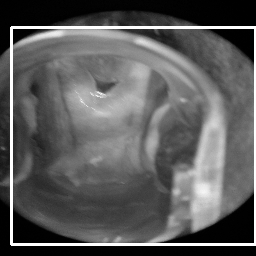

In [191]:
showX(out,dim)

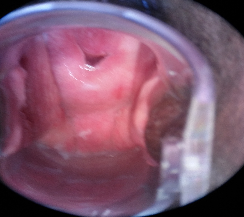

In [183]:
showX(crop,dim)

In [275]:
def seg_cv(imgs):
    
    for _, img in enumerate(imgs):
        print(_, img.shape)
        showX(img[:,:,::-1], imgs.shape[0])
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        showX(img_gray, imgs.shape[0])
        
        ret, threshold = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY)
        
        im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        rects = [cv2.boundingRect(cnt) for cnt in contours]
        showX(im2, imgs.shape[0])
        
        top_x = min([x for (x, y, w, h) in rects])
        top_y = min([y for (x, y, w, h) in rects])
        bottom_x = max([x+w for (x, y, w, h) in rects])
        bottom_y = max([y+h for (x, y, w, h) in rects])
        
        out = cv2.rectangle(img_gray, (top_x, top_y), (bottom_x, bottom_y), (255, 0, 0), 2)
        crop = img[top_y:bottom_y,top_x:bottom_x]
        
        showX(out, imgs.shape[0])   
        showX(crop, imgs.shape[0])  
        
    #return image_gray

0 (256, 256, 3)


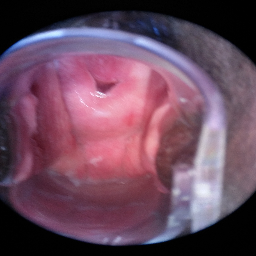

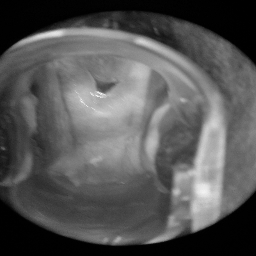

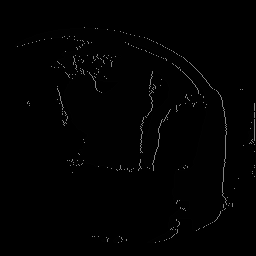

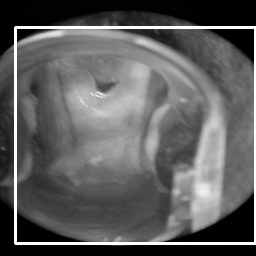

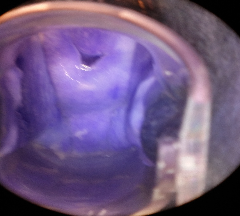

In [276]:
seg_cv(train_data[:1])

In [ ]:
train_data = image_features(train_1['path'], dim)

In [284]:
train_data[0].shape

(256, 256, 3)

In [6]:
def im_multi(path):
    try:
        #print(path)
        im_stats_im_ = cv2.imread(path)
        #print(im_stats_im_.size)
        return [path, {'size': im_stats_im_.size}]
    except:
        print("Error path:%s"%(path))
        return [path, {'size': [0,0]}]
    
def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        #print(ret[i][0])
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join([str(s) for s in str(im_stats_d[x]['size'])]))
    return im_stats_df

In [7]:
def SEG_CV(img):
    
    #print(_, img.shape)
    #showX(img[:,:,::-1], img.shape[0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #showX(img_gray, img.shape[0])

    ret, threshold = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY)

    im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    #showX(im2, img.shape[0])

    top_x = min([x for (x, y, w, h) in rects])
    top_y = min([y for (x, y, w, h) in rects])
    bottom_x = max([x+w for (x, y, w, h) in rects])
    bottom_y = max([y+h for (x, y, w, h) in rects])

    #out = cv2.rectangle(img_gray, (top_x, top_y), (bottom_x, bottom_y), (255, 0, 0), 2)
    crop = img[top_y:bottom_y,top_x:bottom_x]

    #showX(out, img.shape[0])   
    #showX(crop[:,:,::-1], img.shape[0])  
    return crop[:,:,::-1]

In [8]:
img_test = cv2.imread("/home/dataset/train/Type_3/477.jpg")

In [9]:
img_crop = SEG_CV(img_test)

In [10]:
img_gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
#showX(img_gray, img.shape[0])

ret, threshold = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY)

im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(cnt) for cnt in contours]
#showX(im2, img.shape[0])

top_x = min([x for (x, y, w, h) in rects])
top_y = min([y for (x, y, w, h) in rects])
bottom_x = max([x+w for (x, y, w, h) in rects])
bottom_y = max([y+h for (x, y, w, h) in rects])

#out = cv2.rectangle(img_gray, (top_x, top_y), (bottom_x, bottom_y), (255, 0, 0), 2)
crop = img_test[top_y:bottom_y,top_x:bottom_x]

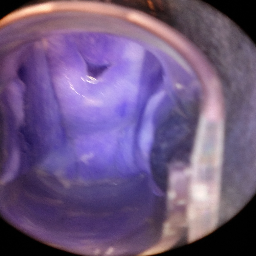

In [18]:
showX(cv2.resize(crop, (256, 256), cv2.INTER_LINEAR),dim)

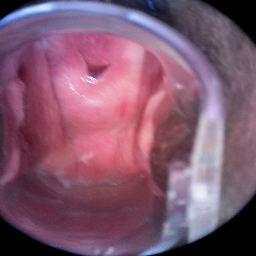

In [19]:
showX(cv2.resize(img_crop[:,:,:], (256, 256), cv2.INTER_LINEAR),dim)

In [38]:
def get_im_cv2(args):
    
    img = cv2.imread(args[0])
    print('start gray')
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, threshold = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    #showX(im2, img.shape[0])

    top_x = min([x for (x, y, w, h) in rects])
    top_y = min([y for (x, y, w, h) in rects])
    bottom_x = max([x+w for (x, y, w, h) in rects])
    bottom_y = max([y+h for (x, y, w, h) in rects])

    #out = cv2.rectangle(img_gray, (top_x, top_y), (bottom_x, bottom_y), (255, 0, 0), 2)
    crop = img[top_y:bottom_y, top_x:bottom_x]

    #print(img_gray.shape)
    print('start resized')
    resized = cv2.resize(crop, (args[1], args[1]), cv2.INTER_LINEAR)
    print(resized.shape)
    return [args[0], resized]

def image_features(paths, dim):
    
    imf_d = {}
    p = Pool(cpu_count())
    dims = [dim for i in range(len(paths.tolist()))]
    params = list(zip(paths.tolist(), dims))
    ret = p.map(get_im_cv2, params)
    #print(ret)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype = np.uint8)
    
    return fdata

In [7]:
train_ = im_stats(train)

In [8]:
train_1 = train_[train_['size'] != '0 0'].reset_index(drop=True) #remove bad images

In [29]:
train_1['path'][:1][0]

'/home/dataset/train/Type_3/477.jpg'

In [39]:
train_data = image_features(train_1['path'], dim)

start gray
start gray
start gray
start gray
start gray
start gray
start gray
start gray
start gray
start gray
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start gray
start gray
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start gray
start gray
start resized
(256, 256, 3)
start gray
start gray
start gray
start gray
start resized
(256, 256, 3)
start gray
start resized
(256, 256, 3)
start gray
start gray
start gray
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start resized
(256, 256, 3)
start gray
start resized
(256, 256, 3)
start gray
start gray
start resized
(256, 256, 3)
start gray
start resized
(256, 256, 3)
start gray
start resized
start resized
(256, 256, 3)
(256, 256, 3)
start gray
start resized
(256, 256, 3)
start gray
start gra

In [40]:
train_data.shape

(1481, 256, 256, 3)

In [59]:
def show(X, dim):
    int_X = X[:,:,:,::-1]
    int_X_reshape = int_X.reshape(-1,dim,dim,3).swapaxes(0,1).reshape(dim,-1,3)
    display(Image.fromarray(int_X_reshape))

In [58]:
showX(train_data[0:20][:, :, :, ::-1], dim)

TypeError: Cannot handle this data type